# MobileNetV2 and VGG-like

#### Connect to Drive:

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1PxSEPrUvbOdLw4oR6K3poPNcUFwahzGX/Homework 1


#### Import libraries:

In [ ]:
pip install keras-cv tensorflow --upgrade

In [ ]:
pip install imagehash

In [ ]:
# Fix randomness and hide warnings:

seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow:

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import keras_cv

In [ ]:
# Import other libraries:

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import PIL
from PIL import Image
import imagehash

In [ ]:
# Import useful items:

from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet import preprocess_input

#### Data import:

In [ ]:
data = np.load('public_data.npz', allow_pickle=True)
X0 = data['data']
y0 = data['labels']
y_aux_0 = y0

#### Data preprocessing:

In [ ]:
# Normalization:
X0 =(X0/255).astype(np.float32)

# One-Hot encoding:
classnames, y0 = np.unique(y0, return_inverse=True)
y0= tfk.utils.to_categorical(y0,2)

In [ ]:
# Outliers removal:

# Shrek:
#plt.imshow(np.clip(X0[58], 0, 255))

# Trol:
#plt.imshow(np.clip(X0[2150], 0, 255))

ref_img_index1 = 58 # Shrek index
ref_img_index2 = 2150 # Trol index

img_1 = (X0[ref_img_index1] * 255).astype(np.uint8)
img_2 = (X0[ref_img_index2] * 255).astype(np.uint8)

hash_1 = imagehash.average_hash(Image.fromarray(img_1))
hash_2 = imagehash.average_hash(Image.fromarray(img_2))

rm_indexes = [ref_img_index1]
rm2_indexes = [ref_img_index2]

for i in range(len(X0)):
    if i != ref_img_index1 and imagehash.average_hash(Image.fromarray((X0[i] * 255).astype(np.uint8))) == hash_1:
        rm_indexes.append(i)
    elif i != ref_img_index2 and imagehash.average_hash(Image.fromarray((X0[i] * 255).astype(np.uint8))) == hash_2:
        rm2_indexes.append(i)

rm_indexes = list(set(rm_indexes))
rm2_indexes = list(set(rm2_indexes))

indexes_to_remove = rm_indexes + rm2_indexes

X = np.delete(X0, indexes_to_remove, axis=0)
y = np.delete(y0, indexes_to_remove, axis=0)
y_aux = np.delete(y_aux_0, indexes_to_remove, axis=0)

In [ ]:
# Inspect the dataset:
print('Dataset shape:')
print(X.shape)
print('Labels vector shape:')
print(y.shape)
labels = np.argmax(y, axis=1)
print('Counting occurrences of target classes:')
print(pd.DataFrame(labels, columns=['digit'])['digit'].value_counts())

Dataset shape:
(5004, 96, 96, 3)
Labels vector shape:
(5004, 2)
Counting occurrences of target classes:
0    3101
1    1903
Name: digit, dtype: int64


In [ ]:
# Data split:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4503, 96, 96, 3), y_train shape: (4503, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)


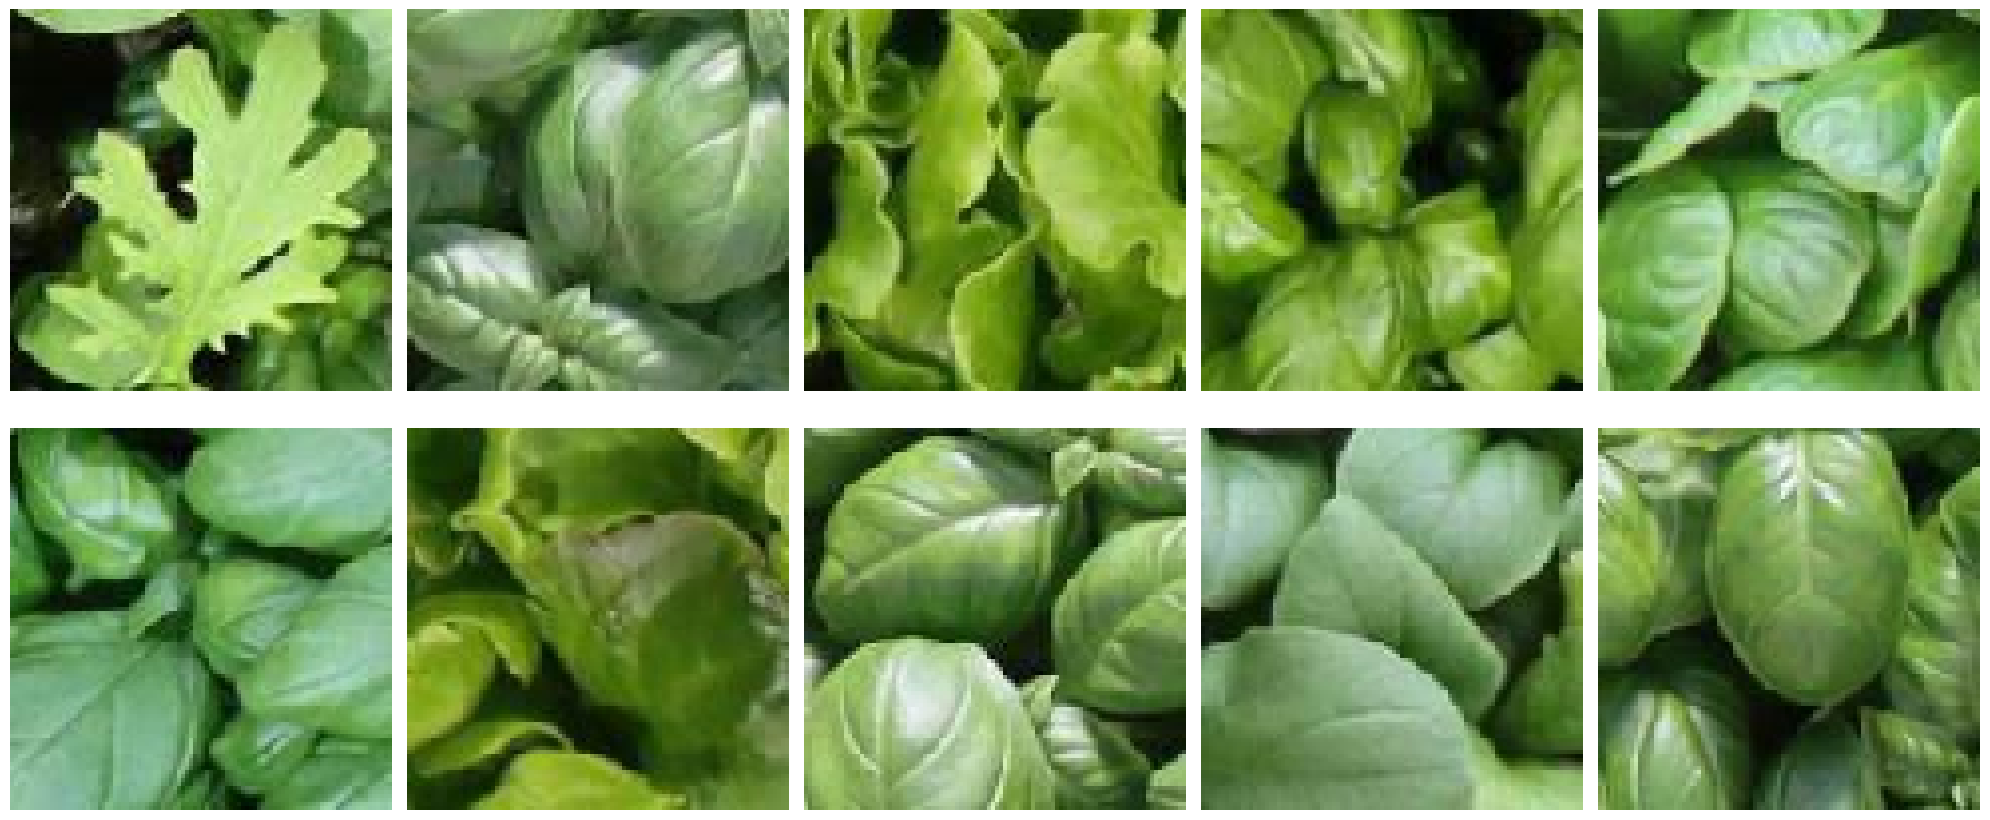

In [ ]:
# Data Visulization:
num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(X0[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

### MobileNetV2:

#### Set parameters:

In [ ]:
batch_size = 64

epochs = 150
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=15, min_lr=1e-5, mode='max')
    ]

# for the tranfer learning part we use different callbacks:
epochs_tl = 20
callbacks_tl=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, min_lr=1e-5, mode='max')
    ]

#### Model contruction:

In [ ]:
# MobileNetV2 model:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet", #PRETRAINED WEIGHTS
    pooling='avg',
)

# Display model architecture:
#tfk.utils.plot_model(mobile, show_shapes=True)

# Contruction:
inputs = tfk.Input(shape=(96, 96, 3))
x = mobile(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

9406464/9406464 [==============================] - 0s 0us/step


#### Transfer Learning:

In [ ]:
# FEN layers are not trainable:
mobile.trainable = False

#model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training:

tl_history = model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs_tl,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = callbacks_tl
).history

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
#model.save('MobileTransferLearning')

#### Fine Tuning:

In [ ]:
#model = tfk.models.load_model('MobileTransferLearning')

In [ ]:
# Freeze first N layers, e.g., until the 115th one
model.get_layer('mobilenetv2_1.00_96').trainable = True
N = 115
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
#for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
#   print(i, layer.name, layer.trainable)

#model.summary()

model.compile(optimizer=tfk.optimizers.AdamW(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training:

ft_history = model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = callbacks
).history

Epoch 1/150
53/55 [===========================>..] - ETA: 0s - loss: 0.9808 - accuracy: 0.4894

KeyboardInterrupt: ignored

In [ ]:
#model.save('MobileFineTuning')

#### Results visualization:

In [ ]:
# Plot the transfer learning and the fine-tuned InceptionV3 training histories:

plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

#### Make inference:

Accuracy: 0.8743
Precision: 0.8759
Recall: 0.8552
F1: 0.8633


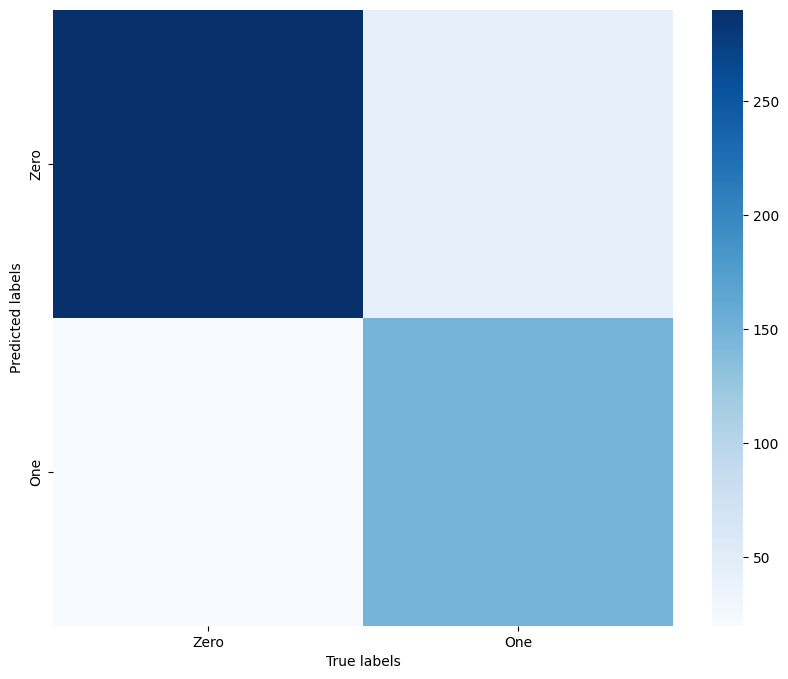

In [ ]:
# Predict labels for the entire validation set:
predictions = model.predict(X_val, verbose=0)

# Compute the confusion matrix:
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics:
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics:
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix:
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### VGG-like architecture, with batch normalization and skip connections:

#### Set parameters:

In [ ]:
batch_size = 128
epochs = 100
#learning_rate = 1e-4
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]

#### Model construction:

In [ ]:
# Define a residual convolutional block with optional batch normalization:

def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
# Define a function to build a VGG18-like model with residual blocks:

def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Define a preprocessing Sequential model with random flip, zero padding, and random crop
    preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
        tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    ], name='Preprocessing')

    # Apply preprocessing to the input layer
    x0 = preprocessing(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense',kernel_regularizer=tf.keras.regularizers.l2(2e-5))(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
# Construction:
residual_model = build_model_residual()
#residual_model.summary()
#tfk.utils.plot_model(residual_model, expand_nested=True, show_shapes=True)

#### Training:

In [ ]:
residual_history = residual_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/100
 1/36 [..............................] - ETA: 48:53 - loss: 2.0997 - accuracy: 0.6328

KeyboardInterrupt: ignored

In [ ]:
residual_model.save('VGG_batch_skip')

#### Make inference:

In [ ]:
# Predict labels for the entire validation set:
predictions = residual_model.predict(X_val, verbose=0)

# Compute the confusion matrix:
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics:
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics:
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix:
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### VGG-like architecture with KerasCV

#### Set parameters:

In [ ]:
batch_size = 128
epochs = 100
learning_rate = 1e-4
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]

#### Model construction:

In [ ]:
# Define a residual convolutional block with optional batch normalization:

def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
# Define a function to build a VGG18-like model with residual blocks:

def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Apply preprocessing to the input layer
    x0=keras_cv.layers.RandomColorDegeneration((0.5,0.5), seed=None, input_shape=input_shape)(input_layer)
    x0=keras_cv.layers.RandomHue((0.5,0.5),[0,1] ,seed=None, input_shape=input_shape)(x0)
    x0=keras_cv.layers.RandomSaturation((0.5,0.5) ,seed=None, input_shape=input_shape)(x0)


    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense',kernel_regularizer=tf.keras.regularizers.l2(2e-5))(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
# Construction:
residual_model = build_model_residual()
#residual_model.summary()
#tfk.utils.plot_model(residual_model, expand_nested=True, show_shapes=True)

#### Training:

In [ ]:
residual_history = residual_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/100
 2/28 [=>............................] - ETA: 34:38 - loss: 2.2121 - accuracy: 0.6172

In [ ]:
residual_model.save('VGG_batch_skip')

#### Make inference:

In [ ]:
# Predict labels for the entire validation set:
predictions = residual_model.predict(X_val, verbose=0)

# Compute the confusion matrix:
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics:
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics:
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix:
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### Data augmentation - todo: add to VGG

In [ ]:
'''
train_datagen =  ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest'
)

valid_datagen = ImageDataGenerator() # transformations are only applied to the training set

train_generator = train_datagen.flow(
  X_train,y_train,
  batch_size=batch_size,
)

validation_generator = valid_datagen.flow(
  X_val,y_val,
  batch_size=batch_size,
)
'''